# Solución a LASSO vía Descenso por Coordenadas. 

Aquí implementamos el Algoritmo 5.1 descrito en el reporte *Análisis Convexo: Subdiferenciales* probandolo con el ejemplo de modelo de criminalidad en libro *Statistical Learning with Sparsity: The LASSO and Generalizations* página 10.

En primer lugar, cargamos la base de datos `crime_data.csv`. En el reporte se indica donde recuperar esta base de datos. 

In [1]:
import numpy as np
import pandas as pd

crime_data = pd.read_csv('crime_data.csv',header=None, usecols=[0,2,3,4,5,6], names=['crime rate','funding','hs','not-hs','college','college4'],dtype=np.float64)

crime_data.head()


,crime rate,funding,hs,not-hs,college,college4
0,478.0,40.0,74.0,11.0,31.0,20.0
1,494.0,32.0,72.0,11.0,43.0,18.0
2,643.0,57.0,70.0,18.0,16.0,16.0
3,341.0,31.0,71.0,11.0,25.0,19.0
4,773.0,67.0,72.0,9.0,29.0,24.0


A continuación, programos algunas funciones auxiliares (como la función *soft thresholding*) además de centrar las variables y normalizar la matriz $X$ de predictores, de forma que las columnas de $X$ tengan media 0 y norma euclideana 1

In [2]:
'''
Datos con media 0 y varianza 1
'''
crime_data_cen=crime_data.subtract(crime_data.mean())
Y=crime_data_cen['crime rate'].copy()
crime_data_cen_and_norm=crime_data_cen.divide(crime_data_cen.std())
crime_data_cen_and_norm['crime rate']=Y
X=crime_data_cen_and_norm.iloc[:,1:].to_numpy()
Y=Y.to_numpy()
'''
Funcion soft-thresholding
'''
def slam(x,lamb):
    if np.abs(x)-lamb>=0:
        value=np.abs(x)-lamb
    else:
        value=0.0
    return np.sign(x)*value

En la siguiente celda mostramos la implementación del Algoritmo 5.1, descrito en detalle en el reporte: *Análisis Convexo: Subdiferenciales*

In [3]:
from sklearn.linear_model import LinearRegression
'''
Descenso por coordenadas para LASSO multipredictor
'''
M,tol=20,np.finfo(float).eps**(1/3) # Fijamos el numero de iteraciones maximo y la tolerancia

def cyclic_coordinate_descent(lamb,X,Y):
    # Condicion initial
    reg_OLS=LinearRegression().fit(X,Y)
    beta_OLS=reg_OLS.coef_
    beta=beta_OLS.copy()
    N,p=X.shape[0],X.shape[1]
    old_beta=beta
    res,k=0,1
    while k<=M:
        if k>1:
            if np.max(np.abs(beta-old_beta))<tol:
                res=1
                return beta,beta_OLS,res
        old_beta=beta
        for j in range(p):
            r=Y-X@beta
            tmp=beta[j]+np.mean(X[:,j]*r)
            beta[j]=slam(tmp,lamb)
        k+=1
    return beta,beta_OLS,res

Finalmente, aplicamos esta función a los datos criminalidad. Para hallar el valor de $\lambda$ ideal, el cual es el punto medio de hacer una restricción muy severa y el sobreajuste, usamos validación cruzada usando $K=10$ grupos. 

In [4]:
'''
Obtenemos lambda por validación cruzada
'''
np.random.seed(1)

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
n_lambdas = 15
lambdas = np.linspace(0.0,120.0,n_lambdas)
n_repeats = 1
n_splits = 10
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None)

MSE_per_lambda_and_K_fold = np.zeros((n_repeats*n_splits, n_lambdas))

n_selected=np.empty(len(lambdas))
dist_to_OLS=np.empty(len(lambdas))



for i, index in enumerate(kf.split(X)):
    train_index, valid_index = index
    X_Kfold, X_valid = X[train_index], X[valid_index]
    y_Kfold, y_valid = Y[train_index], Y[valid_index]

    for j, l in enumerate(lambdas):
        beta_lasso,beta_OLS,res_lasso = cyclic_coordinate_descent(l,X_Kfold,y_Kfold)
        
        hat_y_valid = X_valid@beta_lasso
        '''
        Distancia respecto a OLS y numero de variables seleccionadas
        '''
        n_selected[j]=sum(beta_lasso!=0)
        dist_to_OLS[j]=np.sum(np.abs(beta_lasso))/np.sum(np.abs(beta_OLS))
        '''
        Error cuadratico por grupo y por lambda
        '''
        MSE_per_lambda_and_K_fold[i,j] = mean_squared_error(y_valid, hat_y_valid)
        

mean_MSE = MSE_per_lambda_and_K_fold.mean(axis=0)
std_MSE= MSE_per_lambda_and_K_fold.std(axis=0)
n_selected=n_selected.astype(int)
index_best_lamb=np.argmin(mean_MSE)
best_lamb=lambdas[index_best_lamb]

print('El mejor lambda por CV es: ',best_lamb)
print('La cota relativa con el mejor lambda es: ',dist_to_OLS[index_best_lamb])


El mejor lambda por CV es:  25.714285714285715
La cota relativa con el mejor lambda es:  0.6070444680706486


La cota relativa es parecida a la que se obtiene en el problema con restricción $(0.56)$

Graficamos la curva de la media del error cometido para cada valor de $\lambda$ respecto a $\lVert\hat{\beta}_{LASSO}(\lambda)\rVert_1/\lVert\hat{\beta}_{OLS}\rVert_1$ que es un número en $[0,1]$.

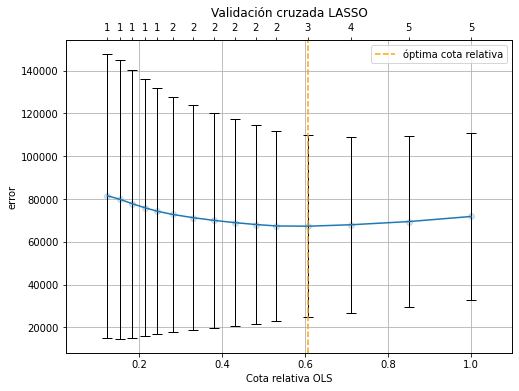

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

# Media del error en CV para cada lambda
ax1.scatter(dist_to_OLS, mean_MSE,alpha=0.2)
ax1.errorbar(dist_to_OLS,mean_MSE,std_MSE, ecolor = 'k', elinewidth = 1, capsize=5)
ax1.axvline(x=dist_to_OLS[index_best_lamb],color='orange',linestyle='--',label='óptima cota relativa')
ax1.legend()
ax1.set_xlim(np.min(dist_to_OLS)-0.1, np.max(dist_to_OLS)+0.1)
ax1.set_xlabel('Cota relativa OLS')
ax1.set_ylabel('error')
ax1.grid(True)


ax2 = ax1.twiny()
ax2.set_xlim(np.min(dist_to_OLS)-0.1, np.max(dist_to_OLS)+0.1)
ax2.set_xticks(dist_to_OLS)
ax2.set_xticklabels(n_selected)
ax2.grid(False)


title = ax1.set_title("Validación cruzada LASSO")
title.set_y(1.1)
fig.subplots_adjust(top=0.85)
plt.show()

Finalmente, obtenemos la traza de LASSO, lo que nos muestra el *grado de importancia* de cada predictor.

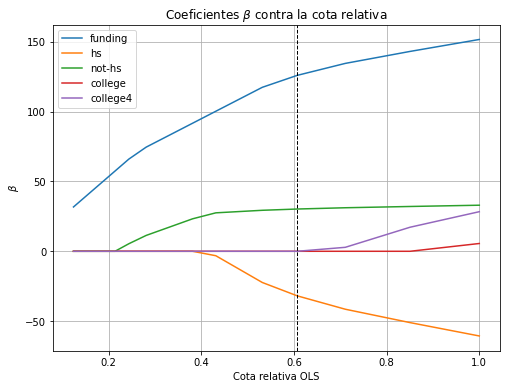

In [6]:
coefs = []

for l in lambdas:
    beta_lasso,beta_OLS,res_lasso = cyclic_coordinate_descent(l,X,Y)
    coefs.append(beta_lasso)


fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.plot(dist_to_OLS,coefs)
ax1.set_xlabel('Cota relativa OLS')
ax1.set_ylabel(r'$\beta$')
ax1.axvline(x=dist_to_OLS[index_best_lamb],color='k',linestyle='--',linewidth=1,label='óptima cota relativa')
ax1.set_title('Coeficientes '+r'$\beta$'+' contra la cota relativa ')
ax1.grid(True)
plt.legend(crime_data.columns[1:])
plt.show()

Finalmente mostramos la solución $\hat{\beta}_{LASSO}(\lambda)$ obtenida con el $\lambda$ calculado por CV.

In [7]:
best_beta_lasso,beta_OLS,res_lasso=cyclic_coordinate_descent(best_lamb,X,Y)
print('Vector de coeficientes obtenido por LASSO con lambda calculado por CV')
print(best_beta_lasso)

Vector de coeficientes obtenido por LASSO con lambda calculado por CV
[126.04256938 -31.92873317  30.28009252  -0.           0.        ]


In [8]:
from sklearn.linear_model import Lasso

reg_lasso_Python=Lasso(alpha=best_lamb,fit_intercept=False,max_iter=20,tol=tol).fit(X,Y)
best_beta_lasso_Python=reg_lasso_Python.coef_
print('La solución LASSO obtenida por Python con el mismo lambda es')
print(best_beta_lasso_Python)

La solución LASSO obtenida por Python con el mismo lambda es
[126.7729288  -18.56700535  19.09516676  -0.          -0.        ]


De lo que se ve que nuestro algoritmo tiene un desempeño razonable, quizás halla error numérico o la inicialización juegue cierto papel.